<a href="https://colab.research.google.com/github/mratanusarkar/Learning-DeepLearning/blob/main/Neural%20Networks%20-%20Zero%20to%20Hero/demo%20examples/binary%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification using micrograd

In [1]:
!git clone https://github.com/mratanusarkar/Learning-DeepLearning.git &> /dev/null
%cd /content/Learning-DeepLearning/Neural\ Networks\ -\ Zero\ to\ Hero
!python setup.py install &> /dev/null

/content/Learning-DeepLearning/Neural Networks - Zero to Hero


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from micrograd.engine import Value
from micrograd.nn import NoobNeuron, NoobLayer, NoobMLP
from micrograd.visualize import draw_dot

In [4]:
np.random.seed(2023)
random.seed(2023)

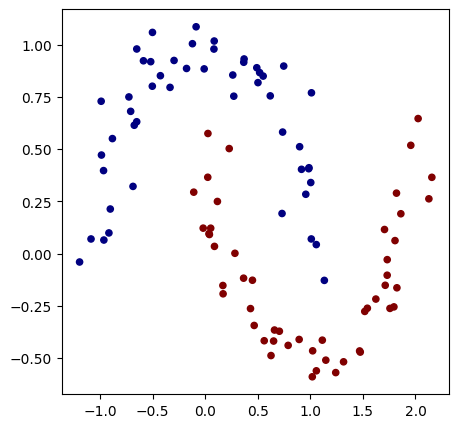

In [5]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [6]:
# initialize a model 
model = NoobMLP(2, [16, 16, 1], nonlin='tanh', label='classifier') # 2-layer neural network
print("number of parameters", len(model.parameters()))

number of parameters 337


In [7]:
# let's make a single forward with a random data to initialize the model and see the metwork
x = [1.0, 1.0]
out = model(x)
print(out)

[Value(label=classifier L:3 N:0 : out, data=-0.2629326584121294, grad=0.0)]


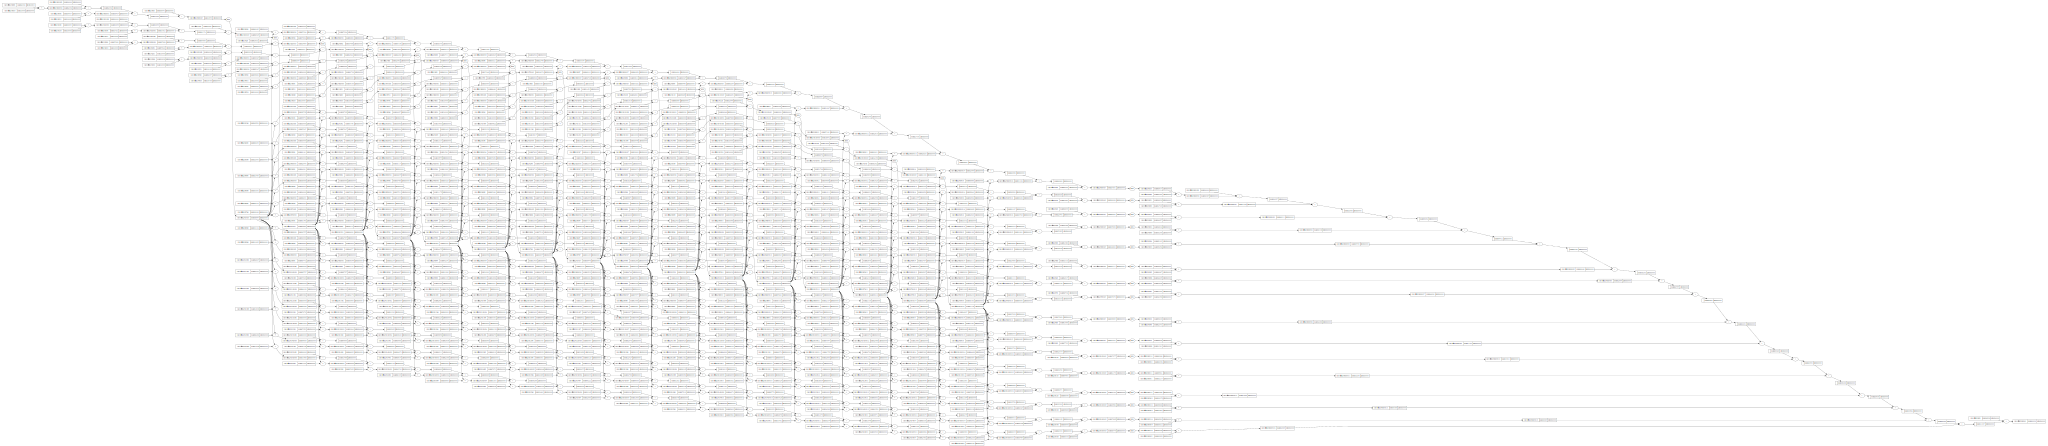

In [8]:
draw_dot(out[0])

In [9]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei[0]).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    total_loss.label = 'total loss'
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei[0].data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print("total_loss:", total_loss, "accuracy:", acc)

total_loss: Value(label=total loss, data=0.9244505060304982, grad=0.0) accuracy: 0.5


In [10]:
# optimization
training_metadata = []
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
    
    meta = {}
    meta['step'] = k
    meta['loss'] = total_loss.data
    meta['accuracy'] = acc*100
    training_metadata.append(meta)

step 0 loss 0.9244505060304982, accuracy 50.0%
step 10 loss 0.23547619700916336, accuracy 92.0%
step 20 loss 0.15772163475844792, accuracy 96.0%
step 30 loss 0.08388587555827103, accuracy 98.0%
step 40 loss 0.025538552615994407, accuracy 100.0%
step 50 loss 0.028438401596154034, accuracy 100.0%
step 60 loss 0.027100855381861605, accuracy 100.0%
step 70 loss 0.018314474901335434, accuracy 100.0%
step 80 loss 0.01817216645601861, accuracy 100.0%
step 90 loss 0.017762170182653053, accuracy 100.0%


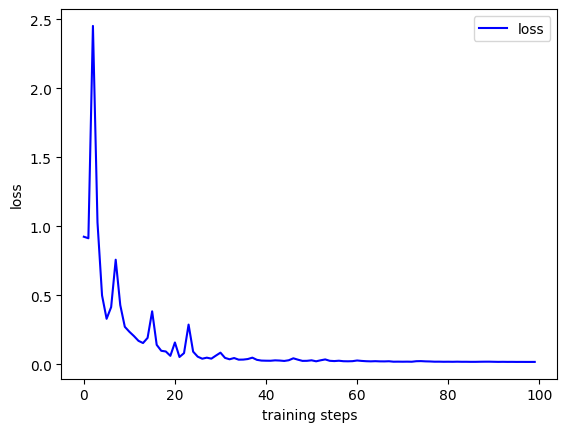

In [11]:
# taking a look at loss w.r.t training steps or iteration count
plt.plot([meta['step'] for meta in training_metadata], [meta['loss'] for meta in training_metadata], 'b', label ='loss')
plt.xlabel("training steps")
plt.ylabel("loss")
plt.legend()
plt.show()

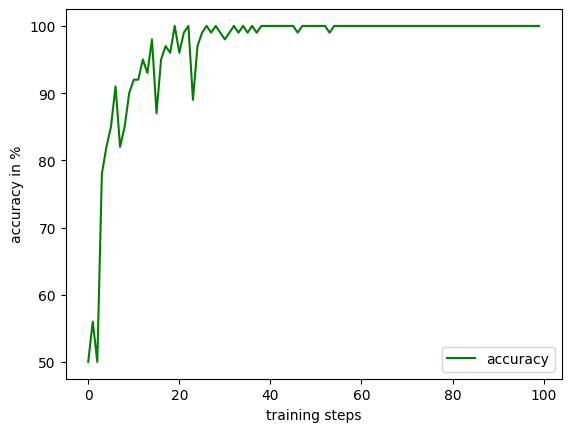

In [12]:
# taking a look at accuracy w.r.t training steps or iteration count
plt.plot([meta['step'] for meta in training_metadata], [meta['accuracy'] for meta in training_metadata], 'g', label ='accuracy')
plt.xlabel("training steps")
plt.ylabel("accuracy in %")
plt.legend()
plt.show()

(-1.590638018514548, 1.909361981485452)

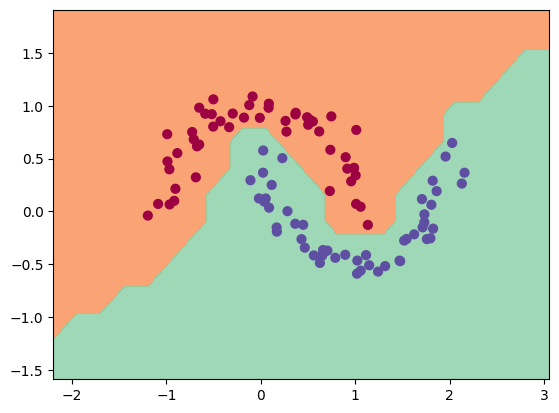

In [13]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[0].data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())